<a href="https://colab.research.google.com/github/CelaPablo/SOA-EA2/blob/master/HPC/Cela_Pablo_ejercicio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Introducción

intro

---
# Armado del ambiente

???

In [ ]:
# Posible armado de ambiente

---
# Desarrollo

???

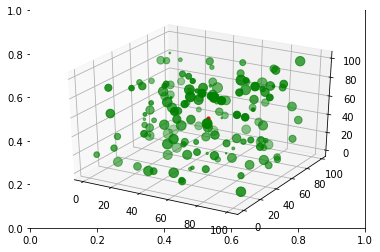

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

cuerpos = 150#@param {type: "number"}
colores = ['green'] * cuerpos

x_cpu  = np.random.uniform(0, 100, size=cuerpos)
y_cpu  = np.random.uniform(0, 100, size=cuerpos)
z_cpu  = np.random.uniform(0, 100, size=cuerpos)
m_cpu  = np.random.uniform(0, 100, size=cuerpos)

cdmx = 0
cdmy = 0
cdmz = 0
masas = 0

m = 0

for i in range( 0, cuerpos ):
  m = m_cpu[i]
  cdmx += x_cpu[i] * m
  cdmy += y_cpu[i] * m
  cdmz += z_cpu[i] * m
  masas += m

cdmx /= masas
cdmy /= masas
cdmz /= masas

fig, ax = plt.subplots()
ax1 = fig.add_subplot(111, projection="3d")
ax1.scatter(x_cpu, y_cpu, z_cpu, c=colores, s=m_cpu)
ax1.scatter(cdmx, cdmy, cdmz, c='red', s=10)

In [108]:

code = """
// Calculo de centro de masas de cuerpos libres con OpenMP - usando C.

#include <iostream>
#include <vector>
#include <cstdlib>
#include <sys/time.h>
#include <omp.h>

// ----------------------------------------------------------------------------
// Macros que miden el tiempo.

static double dHashTiempoHistory[3];
static struct timeval tv;

#define TIEMPO_INI( h )      \
   gettimeofday(&tv,NULL);   \
   dHashTiempoHistory[ h ] = tv.tv_sec + tv.tv_usec/1000000.0;
   
   
#define TIEMPO_FIN( h )      \
   gettimeofday(&tv,NULL);   \
   dHashTiempoHistory[ h ] = ((tv.tv_sec + tv.tv_usec/1000000.0) - dHashTiempoHistory[ h ]) * 1000; // Devuelvo en milisegundos
#define TIEMPO_GET( h ) dHashTiempoHistory[ h ]

#define HTH_TOTAL         1
#define HTH_AXPY_SEC      2
#define HTH_AXPY_OMP      3

// ----------------------------------------------------------------------------

int main(int argc, char* argv[]) 
{ 
  TIEMPO_INI( HTH_TOTAL )

  // Lectura de parametros.
  if( argc != 2 )
  {
      std::cerr<< " Error en los parametros de indicar: (Tamanio vector)."<<argc<<std::endl;
      exit( -1 );
  }

  int cantidad = atoi( argv[1] );

  // --------------------------------------------
  // Defino la memoria de los vectores.

  std::vector<double> x_omp( cantidad );
  std::vector<double> y_omp( cantidad );
  std::vector<double> z_omp( cantidad );
  std::vector<double> m_omp( cantidad );
  
  int i;
  float masas = 0;

  // --------------------------------------------
  // Variables para ejecucion en serie.
  float x_serie = 0, y_serie = 0, z_serie = 0;

  // --------------------------------------------
  // Variables para ejecucion en paralelo.
  float x_paralelo = 0, y_paralelo = 0, z_paralelo = 0;

  // --------------------------------------------
  // Inicializacion de los vectores.
  for (int i=0;i<x_omp.size();i++)
  {
    x_omp[i] = (rand()/(double)RAND_MAX)*0.73;
    y_omp[i] = (rand()/(double)RAND_MAX)*0.73;
    z_omp[i] = (rand()/(double)RAND_MAX)*0.73;
    m_omp[i] = (rand()/(double)RAND_MAX)*0.73;
  }

  // --------------------------------------------
  // Realizo el calculo del centro de masa en forma secuencial.

  TIEMPO_INI( HTH_AXPY_SEC )
  for(i=0;i<cantidad;i++)
  {
    float m = m_omp[i];
    x_serie += x_omp[i] * m;
    y_serie += y_omp[i] * m;
    z_serie += z_omp[i] * m;
    masas += m;
  }

  x_serie /= masas;
  y_serie /= masas;
  z_serie /= masas;

  masas = 0;

  TIEMPO_FIN( HTH_AXPY_SEC )

  // --------------------------------------------
  // Realizo el calculo del centro de masa con OpenMP.

  TIEMPO_INI( HTH_AXPY_OMP )

  #pragma omp parallel shared(masas, x_paralelo, y_paralelo, z_paralelo)
  {
    int id = omp_get_thread_num();
    int nt = omp_get_num_threads();
    int size = cantidad / nt;
    int init = id * size;
    int end = init + size - 1;

    for(i = init; i <= end; i++)
    {
      float m = m_omp[i];
      x_paralelo += x_omp[i] * m;
      y_paralelo += y_omp[i] * m;
      z_paralelo += z_omp[i] * m;
      masas += m;
    }
  }
 
  x_paralelo /= masas;
  y_paralelo /= masas;
  z_paralelo /= masas;

  TIEMPO_FIN( HTH_AXPY_OMP )

  // --------------------------------------------
  // Muestro los resultados.
  std::cout<<"Resulatdos - Posicion del centro de masa:" <<std::endl;
  std::cout<<"Ejecucion en serie: ("<<x_serie<<"; "<<y_serie<<"; "<<z_serie<<")"<<std::endl;
  std::cout<<"Resulatdos - Posicion del centro de masa:" <<std::endl;
  std::cout<<"Ejecucion en paralelo: ("<<x_paralelo<<"; "<<y_paralelo<<"; "<<z_paralelo<<")"<<std::endl;

  TIEMPO_FIN( HTH_TOTAL )

 std::cout<<"Valores Reales :" <<std::endl;
 std::cout<<"Tiempo TOTAL   : "<<TIEMPO_GET(HTH_TOTAL   )<<" [ms]"<<std::endl;
 std::cout<<"Tiempo centro de masa Sec real : "<<TIEMPO_GET(HTH_AXPY_SEC)<<" [ms]"<<std::endl;
 std::cout<<"Tiempo centro de masa Omp real : "<<TIEMPO_GET(HTH_AXPY_OMP)<<" [ms]"<<std::endl;
 std::cout<<std::endl;
 std::cout<<"SpeedUp          : (tiempo Secuencial/tiempo paralelo) : "<<TIEMPO_GET(HTH_AXPY_SEC)<<" / "<<TIEMPO_GET(HTH_AXPY_OMP)<<" = "<<TIEMPO_GET(HTH_AXPY_SEC)/TIEMPO_GET(HTH_AXPY_OMP)<<std::endl;
 std::cout<<"Eficiencia       : SpeedUp/nro procesadores            : "<<TIEMPO_GET(HTH_AXPY_SEC)/TIEMPO_GET(HTH_AXPY_OMP)<<" / "<<omp_get_num_procs()<<" = "<<TIEMPO_GET(HTH_AXPY_SEC)/(omp_get_num_procs()*TIEMPO_GET(HTH_AXPY_OMP))<<std::endl;
 std::cout<<"Coste Sec        : nro procesadores*Tiempo             : "<<1<<" * "<<TIEMPO_GET(HTH_AXPY_SEC)<<" = "<<TIEMPO_GET(HTH_AXPY_SEC)<<std::endl;
 std::cout<<"Coste Omp        : nro procesadores*Tiempo             : "<<omp_get_num_procs()<<" * "<<TIEMPO_GET(HTH_AXPY_OMP)<<" = "<<omp_get_num_procs()*TIEMPO_GET(HTH_AXPY_OMP)<<std::endl;
 std::cout<<"Funcion Overhead : Coste Omp - tiempo Secuencial       : "<<omp_get_num_procs()*TIEMPO_GET(HTH_AXPY_OMP)<<" - "<<TIEMPO_GET(HTH_AXPY_SEC)<<" = "<<(omp_get_num_procs()*TIEMPO_GET(HTH_AXPY_OMP))-TIEMPO_GET(HTH_AXPY_SEC)<<std::endl;
 std::cout<<"-------------------------------------------------------------------------------------"<<std::endl;
 std::cout<<std::endl;
 std::cout<<"Valores Ideal: "<<std::endl;
 TIEMPO_GET(HTH_AXPY_OMP) = TIEMPO_GET(HTH_AXPY_SEC) / 2;
 std::cout<<"Tiempo centro de masa Sec ideal : "<<TIEMPO_GET(HTH_AXPY_SEC)<<" [ms]"<<std::endl;
 std::cout<<"Tiempo centro de masa Omp ideal : "<<TIEMPO_GET(HTH_AXPY_OMP)<<" [ms]"<<std::endl;

 std::cout<<"SpeedUp          : (tiempo Secuencial/tiempo paralelo) : "<<TIEMPO_GET(HTH_AXPY_SEC)<<" / "<<TIEMPO_GET(HTH_AXPY_OMP)<<" = "<<TIEMPO_GET(HTH_AXPY_SEC)/TIEMPO_GET(HTH_AXPY_OMP)<<std::endl;
 std::cout<<"Eficiencia       : SpeedUp/nro procesadores            : "<<TIEMPO_GET(HTH_AXPY_SEC)/TIEMPO_GET(HTH_AXPY_OMP)<<" / "<<omp_get_num_procs()<<" = "<<TIEMPO_GET(HTH_AXPY_SEC)/(omp_get_num_procs()*TIEMPO_GET(HTH_AXPY_OMP))<<std::endl;
 std::cout<<"Coste Sec        : nro procesadores*Tiempo             : "<<1<<" * "<<TIEMPO_GET(HTH_AXPY_SEC)<<" = "<<TIEMPO_GET(HTH_AXPY_SEC)<<std::endl;
 std::cout<<"Coste Omp        : nro procesadores*Tiempo             : "<<omp_get_num_procs()<<" * "<<TIEMPO_GET(HTH_AXPY_OMP)<<" = "<<omp_get_num_procs()*TIEMPO_GET(HTH_AXPY_OMP)<<std::endl;
 std::cout<<"Funcion Overhead : Coste Omp - tiempo Secuencial       : "<<omp_get_num_procs()*TIEMPO_GET(HTH_AXPY_OMP)<<" - "<<TIEMPO_GET(HTH_AXPY_SEC)<<" = "<<(omp_get_num_procs()*TIEMPO_GET(HTH_AXPY_OMP))-TIEMPO_GET(HTH_AXPY_SEC)<<std::endl;

}
// ----------------------------------------------------------------------------

"""
text_file = open("ejercicioTres.cpp", "w")
text_file.write(code)
text_file.close()


In [109]:
!g++ -o ejercicioTres -fopenmp ejercicioTres.cpp

In [117]:
%env OMP_NUM_THREADS=4

env: OMP_NUM_THREADS=4


In [118]:
!./ejercicioTres 15000000

Resulatdos - Posicion del centro de masa:
Ejecucion en serie: (0.366608; 0.366698; 0.366856)
Resulatdos - Posicion del centro de masa:
Ejecucion en paralelo: (0.36448; 0.364475; 0.364975)
Valores Reales :
Tiempo TOTAL   : 1501.09 [ms]
Tiempo centro de masa Sec real : 280.658 [ms]
Tiempo centro de masa Omp real : 81.31 [ms]

SpeedUp          : (tiempo Secuencial/tiempo paralelo) : 280.658 / 81.31 = 3.4517
Eficiencia       : SpeedUp/nro procesadores            : 3.4517 / 2 = 1.72585
Coste Sec        : nro procesadores*Tiempo             : 1 * 280.658 = 280.658
Coste Omp        : nro procesadores*Tiempo             : 2 * 81.31 = 162.62
Funcion Overhead : Coste Omp - tiempo Secuencial       : 162.62 - 280.658 = -118.038
-------------------------------------------------------------------------------------

Valores Ideal: 
Tiempo centro de masa Sec ideal : 280.658 [ms]
Tiempo centro de masa Omp ideal : 140.329 [ms]
SpeedUp          : (tiempo Secuencial/tiempo paralelo) : 280.658 / 140.329 = 

---
# Tabla de pasos de ejecución del programa


 Procesador | Funciòn | Detalle
------------|---------|----------




No se si es necesario --


---
# Conclusión

???

---
# Bibliografía

???